## TRabajo Práctico Número 3  - Logos de Coca-Cola



#### Consiga:

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en la carpeta ./images a partir del template ./template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del item 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
#importar librerías
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from imutils.object_detection import non_max_suppression

### Para mayor legibilidad del ejercicio, se implementarán las funciones como clases. 
#### Clase ImageData: encargada de cargar la imagen en un objeto.
#### Clase TemplateMatcher: contendrá los métodos para realizar la detección del template en la imagen, tanto detección única como múltiples detecciones.

In [2]:
class ImageData:
    """Clase para manejar la carga y procesamiento de imágenes.
    Atributos:
        name (str): Nombre del archivo de imagen.
        img (numpy.ndarray): Imagen original en formato BGR.
        rgb (numpy.ndarray): Imagen convertida a formato RGB.
        gray (numpy.ndarray): Imagen convertida a escala de grises.
        canny (numpy.ndarray): Imagen procesada con el detector de bordes Canny.
    """
    def __init__(self, path):
        self.name = os.path.basename(path)
        self.img = cv.imread(path)
        if self.img is None:
            raise ValueError(f'No se pudo cargar: {self.name}')
        self.rgb = cv.cvtColor(self.img, cv.COLOR_BGR2RGB)
        self.gray = cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)
        self.canny = cv.Canny(self.gray, 100, 180, L2gradient=True)

In [27]:
class TemplateMatcher:
    """Clase para realizar la detección de un template en una imagen.
    Atributos:
        template (numpy.ndarray): Imagen del template en escala de grises.
        template_canny (numpy.ndarray): Imagen del template procesada con el detector de bordes Canny.
        method (int): Método de coincidencia de plantillas de OpenCV.
        scales (list): Lista de escalas para redimensionar la imagen durante la detección.
    """
    def __init__(self, template_path, canny_thresholds=(100, 150), method=cv.TM_CCORR_NORMED, scales=None):
        self.template = cv.imread(template_path, 0)
        self.template_canny = cv.Canny(self.template, *canny_thresholds, L2gradient=True)
        self.method = method
        self.scales = scales if scales is not None else [0.3, 0.65, 0.75, 1, 1.5, 2, 2.5, 4, 4.5]
    
    def detect_single(self, image, manual_scale=False, scale_range=(0.5, 3.0), scale_step=0.1):
        """Detect a single template match (highest score) in the image.
        
        Args:
            image (ImageData): Image data object containing rgb, gray, canny, and name.
            threshold (float): Minimum match score threshold.
            manual_scale (bool): If True, use scale_range and scale_step; otherwise, use predefined scales.
            scale_range (tuple): Range of scales for resizing (start, end).
            scale_step (float): Step size for scale range.
        
        Returns:
            tuple: (rectangle, score, scale) where rectangle is (x1, y1, x2, y2) or None if no detection.
        """
        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)
        
        w, h = self.template.shape[::-1]
        best_score, best_scale, best_loc, best_image_canny = -10, 0, None, None
        r = 1.0

        for s in scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_canny = cv.Canny(image_resized, 100, 180, L2gradient=True)
                res = cv.matchTemplate(image_canny, self.template_canny, self.method)
                min_val, max_val, _, max_loc = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_score = max_val
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_loc = max_loc
                    best_image_canny = image_canny
        
        if best_loc is None:
            print(f"Imagen: {image.name}, No se detectó el template.")
            return None, best_score, best_scale
        
        top_left = (int(best_loc[0] * r), int(best_loc[1] * r))
        bottom_right = (int((best_loc[0] + w) * r), int((best_loc[1] + h) * r))
        rect = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

        return rect, best_score, best_scale, best_image_canny

    def detect_multiple(self, image, threshold=0.140):
        w, h = self.template.shape[::-1]
        rects, scores, best_score, best_scale = [], [], -10, 0
        best_res, r = None, 1.0

        for s in self.scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_canny = cv.Canny(image_resized, 100, 180, L2gradient=True)
                res = cv.matchTemplate(image_canny, self.template_canny, self.method)
                min_val, max_val, _, _ = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_score = max_val
                    best_res = res
        
        if best_res is not None:
            loc = np.where(best_res >= threshold)
            for pt in zip(*loc[::-1]):
                rects.append((int(pt[0] * r), int(pt[1] * r), int((pt[0] + w) * r), int((pt[1] + h) * r)))
                scores.append(best_res[pt[1], pt[0]])
        
        rects = np.array(rects)
        if len(rects) > 0:
            rects = non_max_suppression(rects, probs=scores, overlapThresh=0.3)
        
        return rects, scores, best_score, best_scale
    

    def visualize_single(self, image, rect, best_score, best_scale, image_canny):
        """Visualize a single detection on the image.
        
        Args:
            image (ImageData): Image data object.
            rect (tuple): Rectangle coordinates (x1, y1, x2, y2) or None.
            score (float): Match score for the detection.
            scale (float): Scale used for the detection.
            image_canny (numpy.ndarray): Canny-edged image at the best scale.
        """
        img_rgb_copy = image.rgb.copy()
        if rect is not None:
            cv.rectangle(img_rgb_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 255), 3)
        
        print(f"Imagen: {image.name}")
        print(f"Máximo: {np.round(score, 3)}")
        print(f"Nivel de Confianza:  {np.round(1- best_score,3)}")
        print(f"Escala: {best_scale}")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(self.template_canny, cmap='gray')
        plt.title('Template con bordes de Canny')
        plt.subplot(1, 3, 2)
        plt.imshow(image_canny if image_canny is not None else image.canny, cmap='gray')
        plt.title('Imágen con bordes de Canny')
        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb_copy)
        plt.title(f"Nivel de confianza: {np.round(1 - score, 3)}")
        plt.savefig(f"output/ej1_{image.name}", dpi=300, bbox_inches='tight')
        plt.show()


    def visualize(self, image, rects, best_score, best_scale):
        img_rgb_copy = image.rgb.copy()
        for (x1, y1, x2, y2) in rects:
            cv.rectangle(img_rgb_copy, (x1, y1), (x2, y2), (0, 255, 255), 3)
        plt.figure(figsize=(8, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb_copy)
        plt.title(f"Detecciones: {len(rects)}, Escala: {best_scale}, Score: {np.round(best_score, 3)}")
        plt.subplot(1, 2, 2)
        plt.imshow(self.template_canny, cmap='gray')
        plt.title('Template con bordes de Canny')
        plt.savefig(f"output/ej2_{image.name}", dpi=300, bbox_inches='tight')
        plt.show()

In [20]:
# Load images
image_dir = './images'
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
images = [ImageData(os.path.join(image_dir, f)) for f in image_files]


In [23]:
# Initialize matcher
matcher = TemplateMatcher('./template/pattern.png')

Imagen: COCA-COLA-LOGO.jpg
Máximo: 0.3
Nivel de Confianza: 0.7
Escala: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


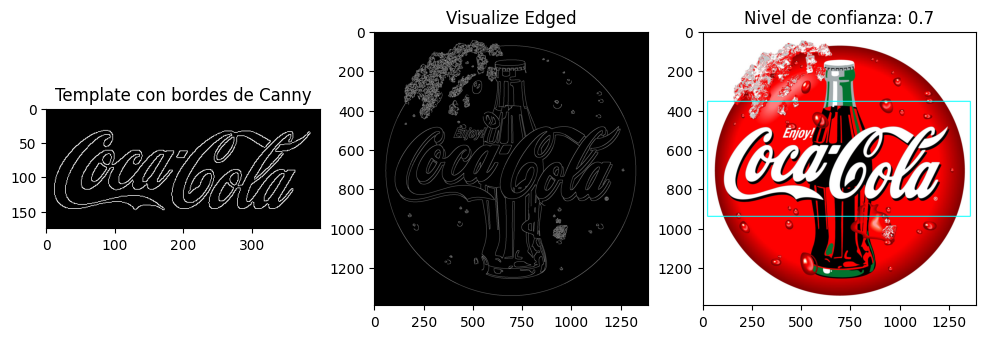

Imagen: coca_multi.png
Máximo: 4
Nivel de Confianza: -3
Escala: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


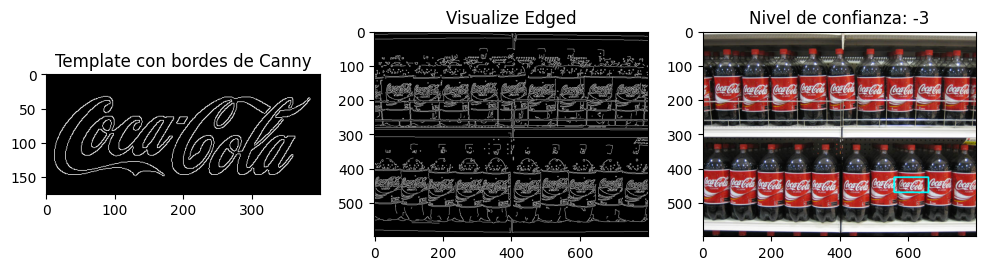

Imagen: coca_logo_1.png
Máximo: 2.5
Nivel de Confianza: -1.5
Escala: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


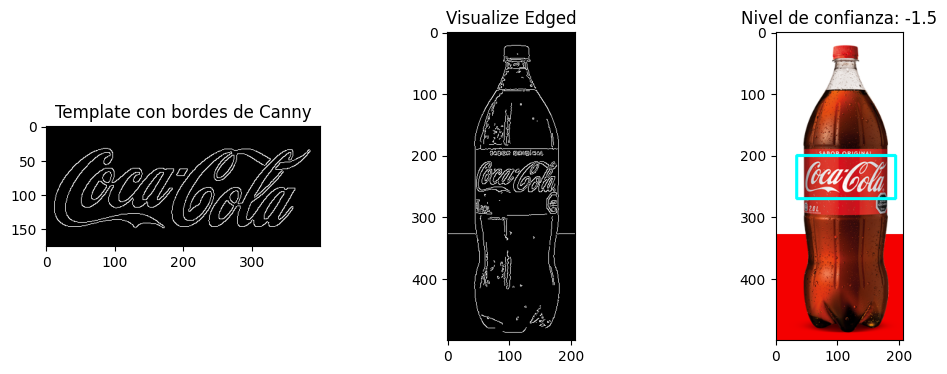

Imagen: coca_retro_1.png
Máximo: 0.75
Nivel de Confianza: 0.25
Escala: [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 255 255]
 [  0   0   0 ... 255 255   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


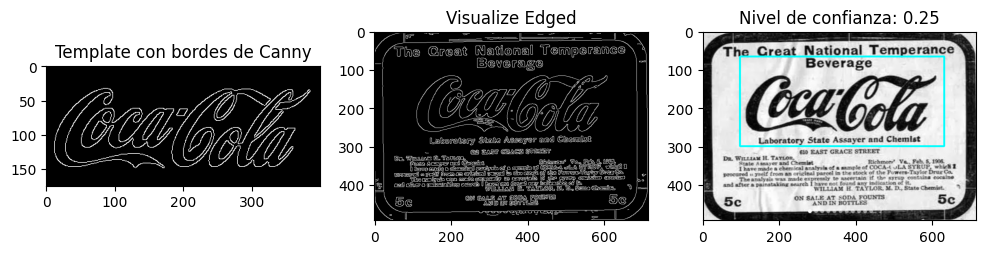

Imagen: logo_1.png
Máximo: 1.5
Nivel de Confianza: -0.5
Escala: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


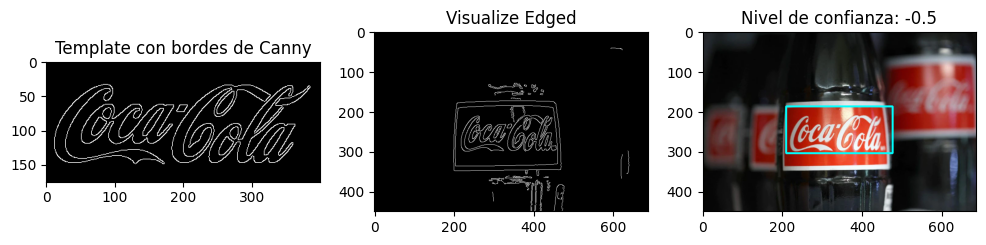

Imagen: coca_logo_2.png
Máximo: 4
Nivel de Confianza: -3
Escala: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


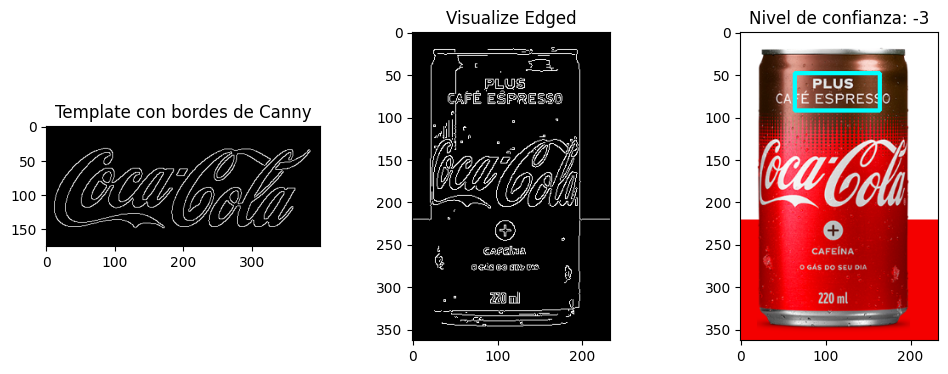

Imagen: coca_retro_2.png
Máximo: 2.5
Nivel de Confianza: -1.5
Escala: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


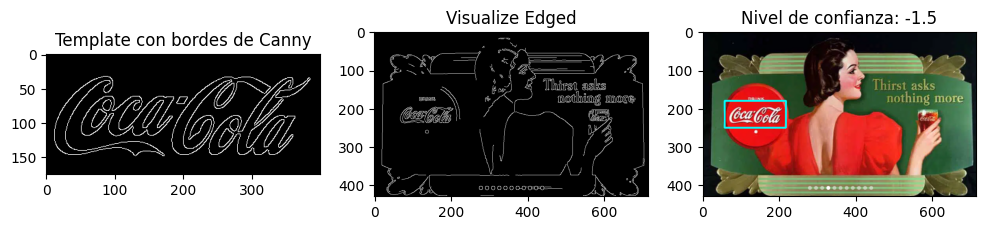

In [26]:
# Process images
for image in images:
    rects, scores, best_score, best_scale = matcher.detect_single(image)
    matcher.visualize_single(image, rects, best_score, best_scale, image.canny)


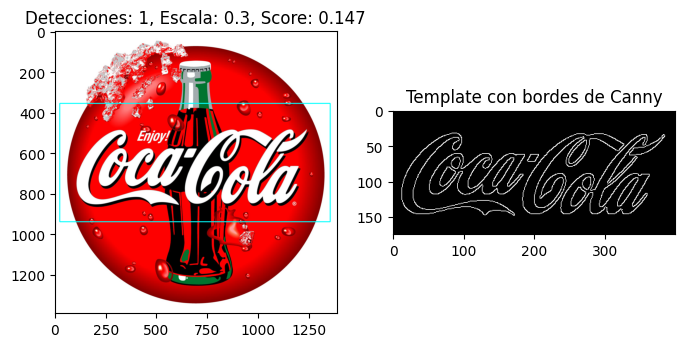

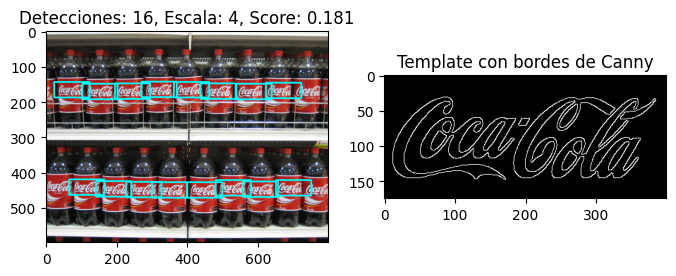

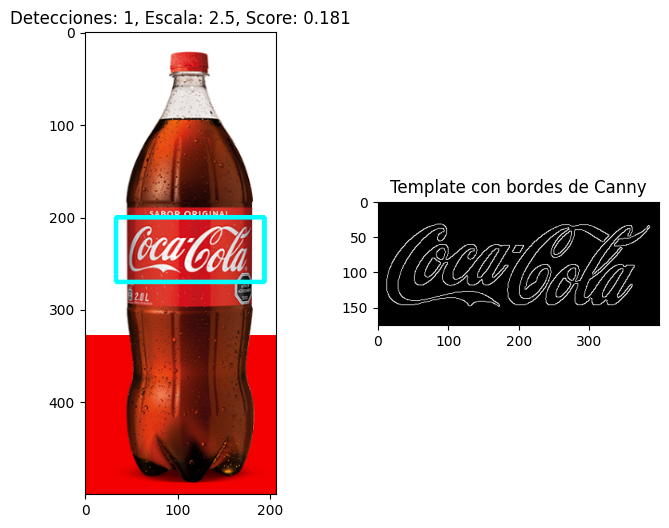

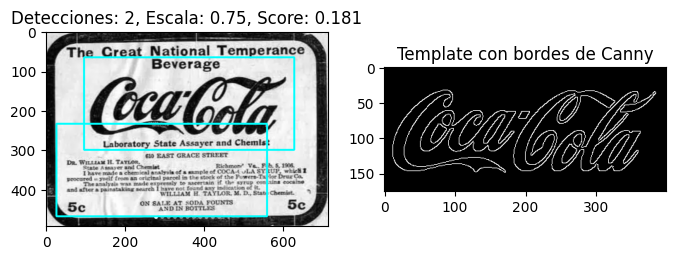

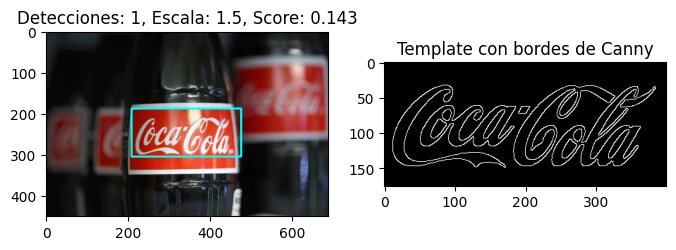

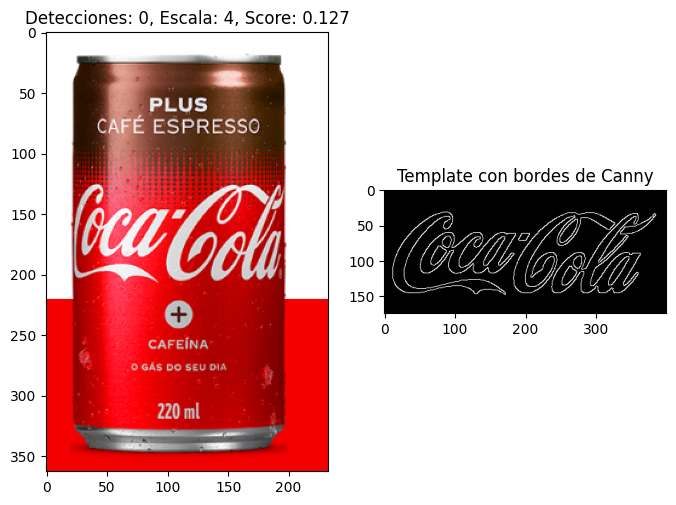

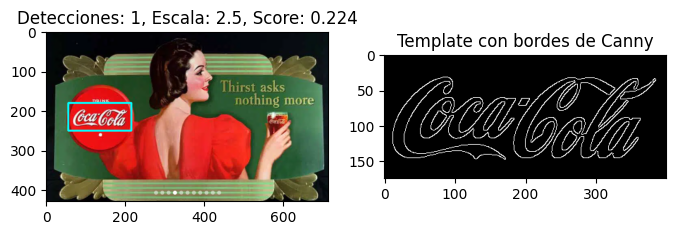

In [9]:
# Process images
for image in images:
    rects, scores, best_score, best_scale = matcher.detect_multiple(image, threshold=0.1420)
    matcher.visualize(image, rects, best_score, best_scale)